In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import pandas_market_calendars as mcal

import warnings

# Suppress the warning
warnings.filterwarnings("ignore")

In [31]:
# data = pd.read_csv('C:/Users/thoma/OneDrive/Documents/QTS/Quant-Trading-Strategies/hw_3_ratio_data.csv')
data = pd.read_csv('/Users/tmac/Desktop/Quant-Trading-Strategies/Quant-Trading-Strategies/hw_3_ratio_data.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('ticker')
data['neg_price_per_earnings'] = data['price_to_earnings']*(-1)

In [32]:
total_ticks = len(data.index.unique())

In [33]:
# libor = pd.read_csv("C:/Users/thoma/Downloads/3-month-libor-rate-historical-chart.csv")
libor = pd.read_csv('/Users/tmac/Downloads/3-month-libor-rate-historical-chart.csv')

In [34]:
libor['date'] = pd.to_datetime(libor['date'])
libor = libor.set_index('date')
libor = libor.loc[libor.index >= pd.to_datetime('2015-01-01')]
date_range = pd.date_range(start='2015-01-01', end='2022-01-31')
libor = libor.reindex(date_range).ffill()
libor['repo'] = libor[' value'] - 1


In [35]:
data = data.reset_index()
data = data.set_index('date')
start_date = pd.to_datetime('2015-01-01')
data = data.loc[data.index >= start_date]
end_date = pd.to_datetime('2022-01-31')
data = data.loc[data.index <= end_date]
data = data.sort_index()
dates = data.index.unique()

In [36]:
def quantile_trading(financial_ratio, quantile_long, quantile_short, initial_k):
    final = pd.DataFrame(columns = ['date', 'pnl_by_date', 'total_pnl'])
    final.loc[0] = [pd.to_datetime('2015-01-04'), 0, 0]
    pnl = 0
    k = initial_k
    for i, day in enumerate(dates):
        day = day.normalize()
        day = day.tz_localize(None)
        if day == pd.to_datetime('2022-01-31'):
            #final close out of position
            #long
            df = data.loc[day]
            df = df.set_index('ticker')
            df = df.loc[ticks_long]
            df =df.join(push_long)
            df['val'] = df['price']*df['shares']
            curr_value_long = df['val'].sum()
            pnl_today = curr_value_long - initial_long_value

            #short
            df = data.loc[day]
            df = df.set_index('ticker')
            df = df.loc[ticks_short]
            df = df.join(push_short)
            df['val'] = df['price']*df['shares']
            curr_value_short = df['val'].sum()
            pnl_today += initial_short_value - curr_value_short + (initial_short_value*libor_td/365)

            k += pnl_today
            pnl+=pnl_today
           
            final.loc[len(final)] = [day, pnl_today, pnl]

        elif i == 0 or (day.month != dates[i-1].month and dates[i-1].day > 20):
            # long
            df = data.loc[day]
            top_ten_percent = df[df[financial_ratio] >= df[financial_ratio].quantile(quantile_long)]
            top_ten_percent = top_ten_percent.set_index('ticker')
            initial_long_value = k/20
            position_per_asset_long = initial_long_value/len(top_ten_percent.index)
            ticks_long = top_ten_percent.index.unique().to_list()
            top_ten_percent['shares'] = position_per_asset_long/top_ten_percent['price']
            push_long = top_ten_percent['shares']
            
            #short
            df = data.loc[day]
            bottom_ten_percent = df[df[financial_ratio] <= df[financial_ratio].quantile(quantile_short)]
            bottom_ten_percent = bottom_ten_percent.set_index('ticker')
            initial_short_value = k/20
            position_per_asset_short = initial_short_value/len(bottom_ten_percent.index)
            ticks_short = bottom_ten_percent.index.unique().to_list()
            bottom_ten_percent['shares'] = position_per_asset_short/bottom_ten_percent['price']
            push_short = bottom_ten_percent['shares']

            #repo rate
            libor_td = libor.loc[day]['repo']

        elif day.month != dates[i+1].month:
            #long
            df = data.loc[day]
            df = df.set_index('ticker')
            df = df.loc[ticks_long]
            df =df.join(push_long)
            df['val'] = df['price']*df['shares']
            curr_value_long = df['val'].sum()
            pnl_today = curr_value_long - initial_long_value 

            #short
            df = data.loc[day]
            df = df.set_index('ticker')
            df = df.loc[ticks_short]
            df = df.join(push_short)
            df['val'] = df['price']*df['shares']
            curr_value_short = df['val'].sum()
            pnl_today += initial_short_value - curr_value_short  + (initial_short_value*libor_td/365)

            k += pnl_today
            pnl+=pnl_today
            

            final.loc[len(final)] = [day, pnl_today, pnl]
    
            pnl_today += initial_short_value - curr_value_short 
    
    return final

        
  

Optimize based on quantiles for debt to market cap

In [205]:
d = -1000000000
for i in tqdm(range(80,99)):
    for j in range(1,20):
        x = quantile_trading('debt_to_market_cap', i/100, j/200, 1000000)
        if x.iloc[-1]['total_pnl'] > d:
            d = x.iloc[-1]['total_pnl']
            params = ('debt_to_market_cap', i/100, j/100, 1000000)
params

100%|██████████| 19/19 [02:14<00:00,  7.09s/it]


('debt_to_market_cap', 0.91, 0.15, 1000000)

In [37]:
debt_t_m = quantile_trading('debt_to_market_cap', .91, .15, 1000000)

Optimize based on quantiles for return on equity

In [240]:
d = -1000000000
for i in tqdm(range(70,99)):
    for j in range(1,30):
        x = quantile_trading('ROI', i/100, j/200, 1000000)
        if x.iloc[-1]['total_pnl'] > d:
            d = x.iloc[-1]['total_pnl']
            params = ('ROI', i/100, j/100, 1000000)
params

100%|██████████| 29/29 [05:11<00:00, 10.76s/it]


('ROI', 0.98, 0.29, 1000000)

In [38]:
roi = quantile_trading('ROI', .98, .29, 1000000)

optimize based on quantiles for price to earnings

In [209]:
d = -1000000000
for i in tqdm(range(80,99)):
    for j in range(1,20):
        x = quantile_trading('price_to_earnings', i/100, j/200, 1000000)
        if x.iloc[-1]['total_pnl'] > d:
            d = x.iloc[-1]['total_pnl']
            params = ('ROI', i/100, j/100, 1000000)
params

100%|██████████| 19/19 [02:12<00:00,  6.99s/it]


('ROI', 0.81, 0.01, 1000000)

In [39]:
price_to_earnings = quantile_trading('price_to_earnings', .81, .01, 1000000)

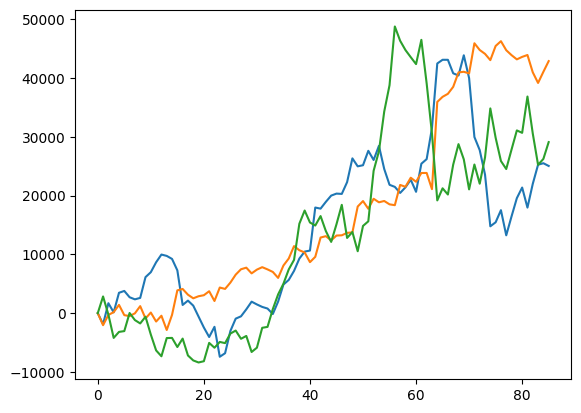

In [40]:
plt.plot(roi['total_pnl'])
plt.plot(debt_t_m['total_pnl'])
plt.plot(price_to_earnings['total_pnl'])